In [1]:
import os
os.chdir('..')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = Path().cwd() / 'data'

In [5]:
path_img = path / 'task1_train'
path_lbl = path / 'task1_masks'

In [6]:
get_mask = lambda x: path_lbl/f'{x.stem}_mask.png'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_6_Or 5593_0024.tif'),
 PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_13_Or 13006_0169.tif'),
 PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_0_Add MS 23494_0031.tif')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_12_Add MS 7474_0028_mask.png'),
 PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_12_Or 3366_0111_mask.png'),
 PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_9_Or 5593_0034_mask.png')]

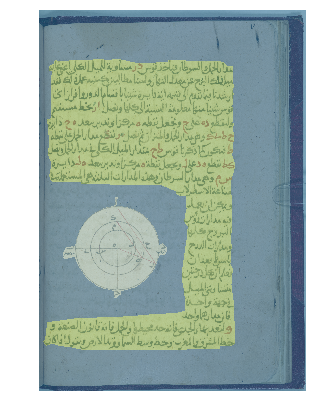

In [9]:
img_f = fnames[0]
img = open_image(img_f)
mask = open_mask(get_mask(img_f))

img.show(y=mask, figsize=(10,7))

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([8415, 5897]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [13]:
# For unet learner size should be even and best is a multiple of 32
size = src_size // 18 ; size

array([467, 327])

In [14]:
size = (468, 328)

In [15]:
class_labels = [
    'page',
    'paragraph',
    'marginalia',
    'caption',
    'graphic',
    'page-number',
    'other'
]

In [16]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_mask, classes=class_labels))

In [18]:
bs = 8

In [19]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0, max_lighting=None, max_warp=None, p_affine=0, p_lighting=0) 
data = (src.transform(tfms=tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=16)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [20]:
wd=1e-2

In [21]:
# TODO - mask page class for pixel accuracy?
def pixel_accuracy_with_mask(input, target):
    void_code = 0
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pixel_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [22]:
def iou_dice(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [23]:
learn = unet_learner(data, models.resnet18, wd=wd, metrics=[pixel_accuracy, pixel_accuracy_with_mask, iou_dice])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


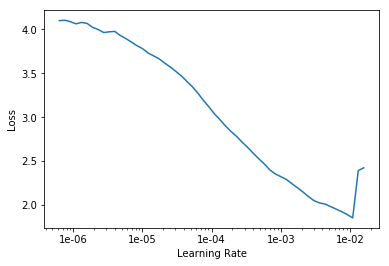

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=1e-4

In [26]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,pixel_accuracy_with_mask,iou_dice,time
0,2.249342,0.994051,0.737576,0.702627,0.803457,02:22
1,1.056012,0.337776,0.882614,0.872324,2.871572,02:22
2,0.586026,0.193893,0.930128,0.951132,-0.558806,02:21
3,0.356691,0.155389,0.948852,0.942883,58.174335,02:20
4,0.239665,0.142254,0.950505,0.963224,12.070525,02:22
5,0.174676,0.119060,0.957470,0.981911,13.934404,02:22
6,0.134842,0.094563,0.964251,0.973166,-13.544238,02:21
7,0.112584,0.092384,0.965313,0.968278,-15.020323,02:21
8,0.095797,0.092038,0.965175,0.967717,-18.541563,02:23
9,0.086842,0.086017,0.967360,0.969951,-16.699732,02:19


In [27]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

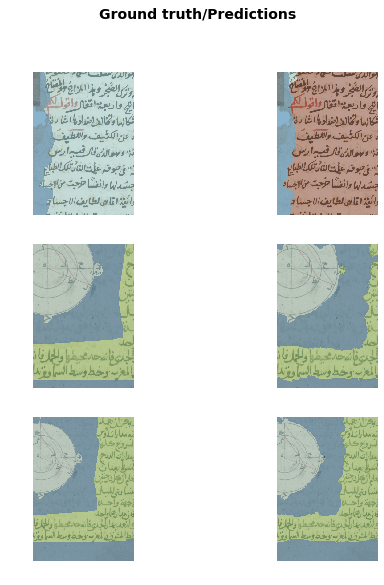

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,pixel_accuracy,pixel_accuracy_with_mask,iou_dice,time
0,0.084587,0.083930,0.968056,0.979188,-33.700325,02:15
1,0.096580,0.111798,0.959044,0.975751,-39.504341,02:17
2,0.088661,0.082598,0.968104,0.971923,-7.077384,02:18
3,0.083356,0.080207,0.969555,0.975876,38.615284,02:20
4,0.084065,0.079753,0.969505,0.969698,-27.739695,02:18
5,0.075967,0.083774,0.968155,0.962724,-15.704616,02:20
6,0.071276,0.077806,0.970508,0.985619,-8.773268,02:20
7,0.068610,0.073441,0.971517,0.971141,-11.471210,02:22
8,0.063109,0.070314,0.972610,0.976006,-8.114096,02:19
9,0.061043,0.072291,0.971949,0.972786,-6.908473,02:17


In [33]:
learn.save('stage-2');

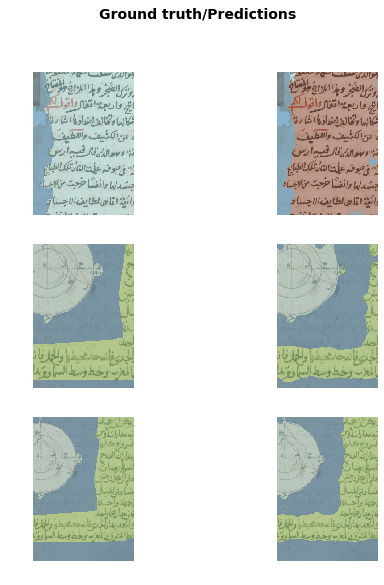

In [34]:
learn.show_results(rows=3, figsize=(8, 9))

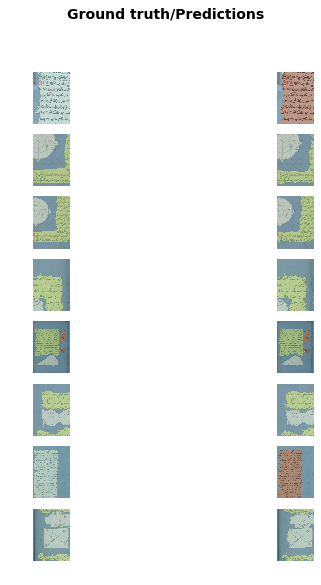

In [38]:
learn.show_results(rows=10, figsize=(8,9))

In [37]:
src_size

array([8415, 5897])